# 

# Kaggle - Benetech - Making Graphs Accessible. Use ML to create tabular data from graphs
This notebook presents the first step in the above Kaggle competition where the goal is to extract data from graph images so that they can be shared in a more accessible fashion to students with learning disabilities. More details regarding the overall goal is present here: (https://www.kaggle.com/competitions/benetech-making-graphs-accessible/overview)

The simplest step for this competition is the first operation, which requires creating an image classification model to classify the different graph types presented in the training dataset:
- Bar graphs (both vertical and horizontal)
- Scatter Plots
- Line graphs

In this notebook we create a quick graph image classifier using *fastai*. The fastai library enables us to quickly stand up an image classifier framework using an existing pre-trained model (we used resnet18) and move on to the next steps in the competition, which requires training a Object Detection Network and a OCR solution (we present those in upcoming notebooks). 

Note: some parts of this notebook re-uses code from different sample notebooks and the relevant sources have been cited in the individual cells.

In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
# Import all relevant fastai modules 
from fastbook import *
from fastai.vision.widgets import *
from fastai.vision.all import *
import re
import os
from glob import glob
from tqdm import tqdm

## Read training data

In [4]:
data_dir = "data/"
os.listdir(data_dir)

['train',
 'sample_submission.csv',
 'IMG-6772.JPG',
 'benetech-making-graphs-accessible.zip',
 'test']

Helper functions to extract bounding boxes from input annotations. These will be used in later steps of the competition but we include it here to be referred to later.


In [5]:
#source:https://www.kaggle.com/code/alejopaullier/benetech-create-bounding-box-dataframe

def extract_plot_bb(data):
    x0 = data["plot-bb"]["x0"]
    y0 = data["plot-bb"]["y0"]
    w = data["plot-bb"]["width"]
    h = data["plot-bb"]["height"]
    return [x0, y0, w, h, "plot-bb"]


def extract_label_bbox(data, rows, img_id):
    common = []
    common+= [img_id, data["source"], data["chart-type"]]
    for box in data["text"]:
        x0 = box["polygon"]["x0"]
        y0 = box["polygon"]["y0"]
        w = box["polygon"]["x1"] - box["polygon"]["x0"]
        h = box["polygon"]["y3"] - box["polygon"]["y0"]
        label = box["role"]
        box_row = common + [x0, y0, w, h, label]
        rows.append(box_row)
    rows.append(common + extract_plot_bb(data)) 
    return rows

def extract_tick_bbox(data, rows, img_id):
    common = []
    common+= [img_id , data["source"], data["chart-type"]]
    for axis in data["axes"].keys():
        for box in data["axes"][axis]["ticks"]:
            x0 = box["tick_pt"]["x"] - 5
            y0 = box["tick_pt"]["y"] - 5
            w = 10
            h = 10
            label = axis + "-tick"
            box_row = common + [x0, y0, w, h, label]
            rows.append(box_row)
    return rows


Read all the input annotations from the training data JSON. 

In [6]:
rows = []
annotations = data_dir + "/train/annotations/*.json"
for file_name in tqdm(glob(annotations)):
    label_bbox = []
    tick_bbox = []
    with open(file_name) as f:
        data = json.load(f)
        img_id = file_name.split("/")[-1].split(".")[0]
        label_bbox = extract_label_bbox(data, label_bbox, img_id)
        tick_bbox = extract_tick_bbox(data, tick_bbox, img_id)
        data_rows = label_bbox + tick_bbox
    rows += data_rows

100%|██████████| 60578/60578 [01:45<00:00, 575.46it/s]


In [7]:
df = pd.DataFrame(rows)
df.columns = ["image_id", "source", "chart", "x0", "y0", "w", "h", "label"]
df.head()

,image_id,source,chart,x0,y0,w,h,label
0,3750aeae65d4,generated,dot,197,11,187,16,chart_title
1,3750aeae65d4,generated,dot,278,274,31,11,axis_title
2,3750aeae65d4,generated,dot,18,130,44,27,axis_title
3,3750aeae65d4,generated,dot,64,37,14,10,tick_label
4,3750aeae65d4,generated,dot,69,57,8,10,tick_label


In [8]:
df_images_labels = df[["image_id","chart"]].drop_duplicates().reset_index(drop=True)
df_images_labels.head()

,image_id,chart
0,3750aeae65d4,dot
1,e4e8c2e922a1,line
2,c49959833442,line
3,06ab2b442644,line
4,e9d7e0e7fcb0,scatter


Some of these helper functions have been refactored/re-used from (https://github.com/Oyekanmi/Make_Graph_Accessible/blob/main/StepA_ImageClassification.ipynb) in collaboration with (https://github.com/Oyekanmi)

In [9]:
#let's append the corresponding file paths to the dataframe
import glob
img_paths = glob.glob(data_dir + "/train/*/**.jpg", recursive=True)

The overall paths and bounding boxes of each graph type from the input JSON is now obtained.

In [10]:
def sort_pths_to_df(img_paths):
    image_ids=[]
    paths=[]
    for each_path in img_paths:
        image_ids.append(each_path.split("/")[-1].split(".")[0])
        paths.append(each_path)
    
    df = pd.DataFrame()
    df["image_id"]=image_ids
    df["paths"]=paths
    
    return df

paths_df = sort_pths_to_df(img_paths)
paths_df.head()

,image_id,paths
0,83784dd85291,data//train/images/83784dd85291.jpg
1,c538cfb06ad4,data//train/images/c538cfb06ad4.jpg
2,0b3e27f00e95,data//train/images/0b3e27f00e95.jpg
3,ffe2211f1547,data//train/images/ffe2211f1547.jpg
4,4750b6119027,data//train/images/4750b6119027.jpg


In [11]:
#merge the paths to the original df
final_df = df_images_labels.merge(paths_df,left_on="image_id", right_on="image_id", how="left")
final_df.head()

,image_id,chart,paths
0,3750aeae65d4,dot,data//train/images/3750aeae65d4.jpg
1,e4e8c2e922a1,line,data//train/images/e4e8c2e922a1.jpg
2,c49959833442,line,data//train/images/c49959833442.jpg
3,06ab2b442644,line,data//train/images/06ab2b442644.jpg
4,e9d7e0e7fcb0,scatter,data//train/images/e9d7e0e7fcb0.jpg


In [12]:
working_df = final_df.copy()

## FastAI image training
We now create a simple FastAI image datablock based on the dataframe of input images (and their paths + classifications) above, resize the images to 224px, split the dataset randomly to a training/test split of 80/20 and carry out a basic set of image transformations provided by the FastAI library

In [13]:
graphs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_x=ColReader(2),
    get_y=lambda o:o.chart,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(224),
    batch_tfms=aug_transforms())

Note that the transformations have randomly rotated, padded and changed the orientation of the various graphs.

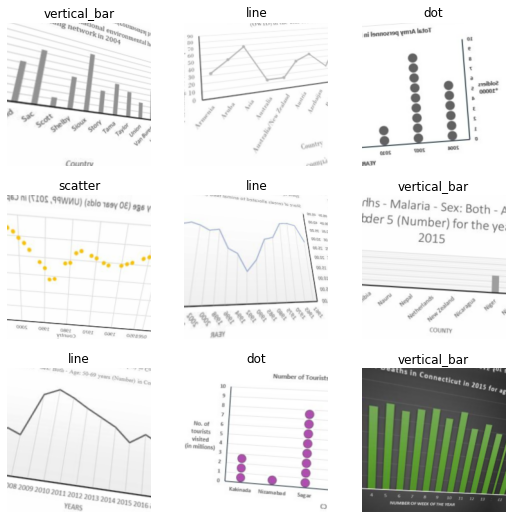

In [14]:
dls = graphs.dataloaders(working_df)
dls.show_batch()

In [15]:
len(dls.train), len(dls.valid), len(final_df)

(757, 190, 60578)

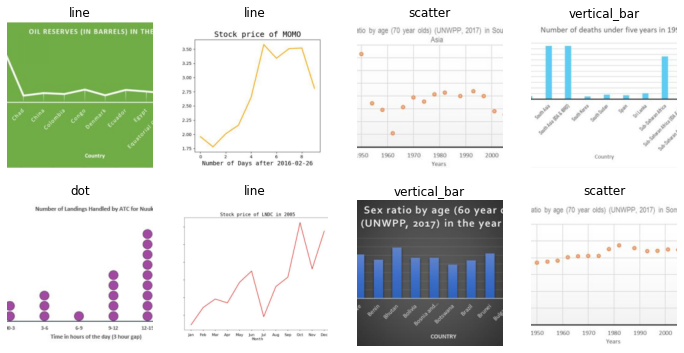

In [16]:
dls.valid.show_batch(max_n=8, nrows=2)

## Training
Start training the model and check if a GPU is present. We use a pre-trained resnet18 model since the graphs are inherently simple and does not require the complexity of larger models such as resnet34, resnet50 or higher.

In [17]:
print(torch.cuda.is_available())

True


In [28]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.model.cuda()
learn.fine_tune(10)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.044093,0.016918,0.004292,02:25


epoch,train_loss,valid_loss,error_rate,time
0,0.014199,0.012728,0.002724,03:09
1,0.015311,0.008870,0.002064,03:11
2,0.017622,0.011838,0.002476,03:11
3,0.010947,0.007588,0.002064,03:11
4,0.016263,0.008956,0.001981,03:12
5,0.007033,0.009068,0.001733,03:11
6,0.009138,0.008845,0.001733,03:12
7,0.005476,0.007248,0.001898,03:12
8,0.004802,0.007276,0.001733,03:10
9,0.002803,0.006950,0.001651,03:12


We train only for 10 epochs as we see that the error rate is already quite low, i.e. < 0.1%. 

## Results
We now look at the results of our predictive classifier. 

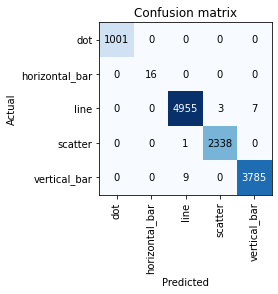

In [29]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The confustion matrix shows that the errors lie mainly among the line graphs; 3 of them are predicted as scatter graphs and 7 as vertical bars. We check the individual images with the worst losses below and actually notice that for the mis-classified images, the top few are actually mis-labeled leading to the errors. We can simply remove these images and re-train the model or keep them in as well as they do not affect the overall accuracies significantly

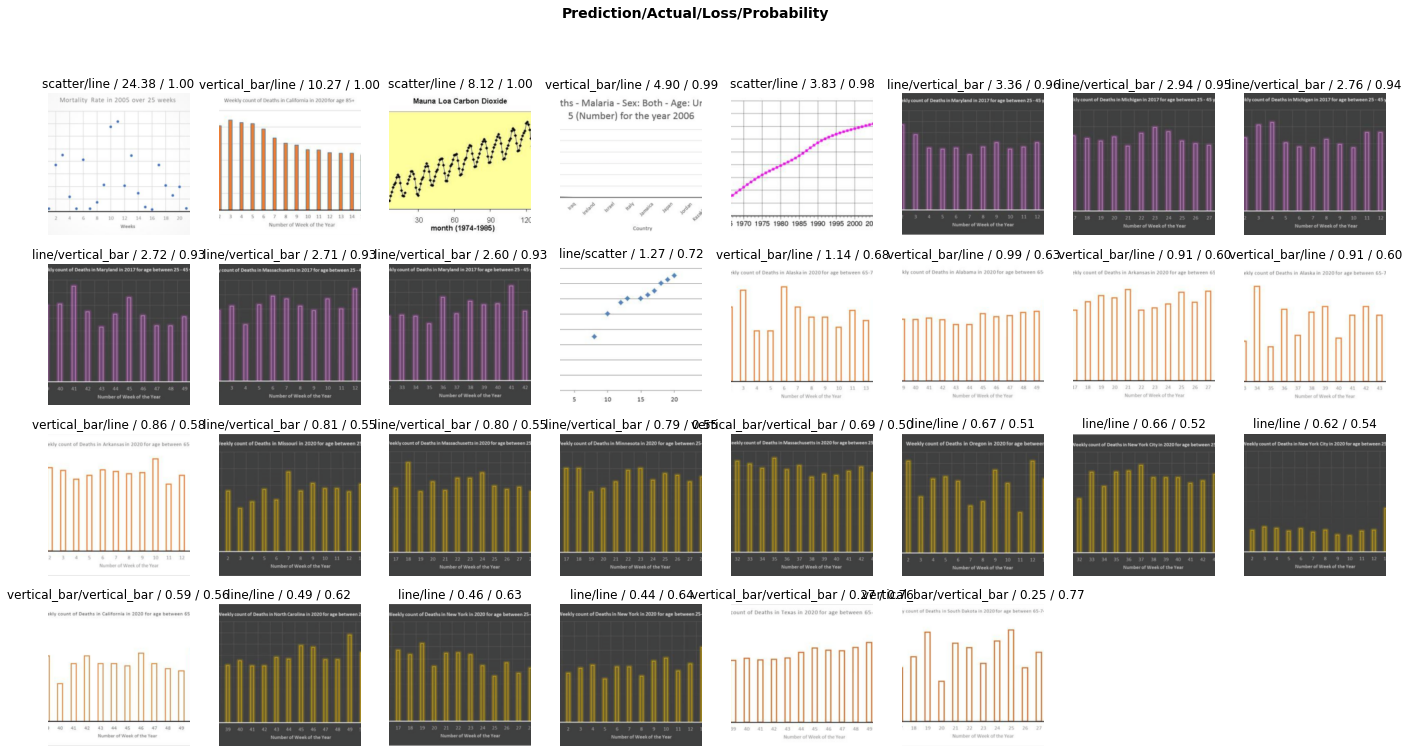

In [30]:
interp.plot_top_losses(30, nrows=4)

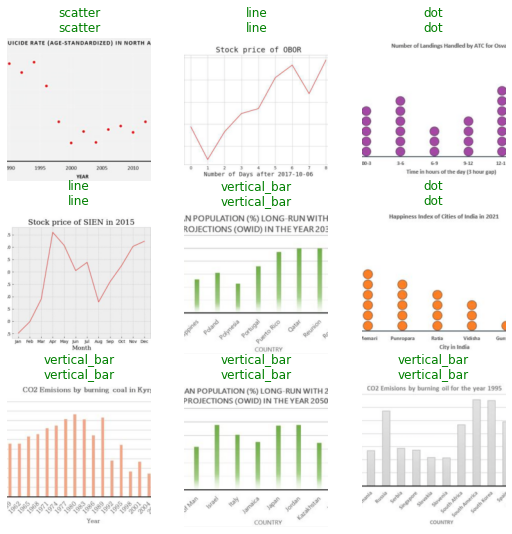

In [25]:
learn.show_results()

Overall, here we have created a simple image classifier with an extremely high accuracy to classify our inputs in to various graph types. Using fastai makes coming up with this type of image classifier extremely easy and quick and also enables us to move forward to the next steps in the competition.